# Pay Day Strategy

In [1]:
# Packages
import datetime as dt
import pandas as pd
import yfinance as yf

import available as avb
import utils as self_utils
from quantified_strategies import strategy_utils as utils

In [2]:
def get_data(ticker: str) -> pd.DataFrame:
    px = utils.get_data(ticker=ticker, columns="Adj Close")
    px = px.to_frame(name=ticker)
    return px


## Rules

1. Buy the close on the fifth last trading day of the month; and,
2. Sell at the close of the first trading day of the new month. 

In [3]:
BUY_LAST_N_TRADING_DAYS = 5
# NOTE: different to rules
SELL_FIRST_N_TRADING_DAYS = 3

# Interactive Brokers (Cost per share)
COST = 0.005

START = dt.date(2020, 1, 1)
END = dt.date.today()

In [4]:
TICKER = "IWM"
# TICKER = "SPY"
# TICKER = "QQQ"
# TICKER = "^FCHI"

In [5]:
# Results are slightly different as below uses datetime trading days while script uses trading days determined by data
results = self_utils.run(ticker=TICKER, full=True, start=START, end=END, buy_nth_last_day=BUY_LAST_N_TRADING_DAYS, sell_nth_first_day=SELL_FIRST_N_TRADING_DAYS-1)
results

{}
remove api from here


,asset,ret,ret_shifted,active,strat_ret,cum_strat_ret,cum_hodl_ret,enter_flag,trade_number
Date,,,,,,,,,
2020-01-02,157.2637,NaN,-0.003921,True,-0.003921,-0.003921,-0.003921,False,0
2020-01-03,156.6471,-0.003921,0.001332,False,0.0,-0.003921,-0.002594,False,0
2020-01-06,156.8558,0.001332,-0.003326,False,-0.0,-0.003921,-0.005911,False,0
2020-01-07,156.3341,-0.003326,0.003095,False,0.0,-0.003921,-0.002835,False,0
2020-01-08,156.8179,0.003095,0.001210,False,0.0,-0.003921,-0.001628,False,0
...,...,...,...,...,...,...,...,...,...
2024-02-27,204.0000,0.014169,-0.008235,True,-0.008235,0.238144,0.286502,False,50
2024-02-28,202.3200,-0.008235,0.006969,True,0.006969,0.246773,0.295467,False,50
2024-02-29,203.7300,0.006969,0.010602,True,0.010602,0.259992,0.309202,False,50


### Get Data

In [6]:
data = get_data(ticker=TICKER)
data.head(5)

{}
remove api from here


,IWM
Date,
2000-05-26,33.4857
2000-05-30,34.7217
2000-05-31,34.8475
2000-06-01,35.6372
2000-06-02,37.4912


In [7]:
data = data.loc[(data.index.date >= START) & (data.index.date <= END)]

### Set-up to get data

In [8]:
data["year_month"] = data.index.map(lambda date: float(dt.datetime.strftime(date, "%Y.%m")))

### Get exit trading day of each month

In [9]:
first_n_trading_days_in_month = data.reset_index(names="exit_date").groupby("year_month").head(SELL_FIRST_N_TRADING_DAYS)
nth_first_trading_day_in_month = first_n_trading_days_in_month.groupby("year_month").last()
nth_first_trading_day_in_month = nth_first_trading_day_in_month.rename(columns={TICKER: "exit"})
nth_first_trading_day_in_month.head(5)

,exit_date,exit
year_month,,
2020.01,2020-01-06,156.8558
2020.02,2020-02-05,158.7151
2020.03,2020-03-04,144.3434
2020.04,2020-04-03,99.6292
2020.05,2020-05-05,120.6083


### Get enter trading day of each month

In [10]:
last_n_trading_days_in_month = data.reset_index(names="enter_date").groupby("year_month").tail(BUY_LAST_N_TRADING_DAYS)
nth_last_trading_day_in_month = last_n_trading_days_in_month.groupby("year_month").first()
nth_last_trading_day_in_month.head(5)

,enter_date,IWM
year_month,,
2020.01,2020-01-27,155.1103
2020.02,2020-02-24,153.7443
2020.03,2020-03-25,104.7240
2020.04,2020-04-24,116.5706
2020.05,2020-05-22,128.4552


In [11]:
last_n_trading_days_in_month

,enter_date,IWM,year_month
16,2020-01-27,155.1103,2020.01
17,2020-01-28,156.4005,2020.01
18,2020-01-29,155.5088,2020.01
19,2020-01-30,155.5088,2020.01
20,2020-01-31,152.2834,2020.01
...,...,...,...
1044,2024-02-27,204.0000,2024.02
1045,2024-02-28,202.3200,2024.02
1046,2024-02-29,203.7300,2024.02
1047,2024-03-01,205.8900,2024.03


In [12]:
nth_last_trading_day_in_month_shifted = nth_last_trading_day_in_month.shift(1)
nth_last_trading_day_in_month_shifted = nth_last_trading_day_in_month_shifted.rename(columns={TICKER: "enter"})
nth_last_trading_day_in_month_shifted.head(5)

,enter_date,enter
year_month,,
2020.01,NaT,NaN
2020.02,2020-01-27,155.1103
2020.03,2020-02-24,153.7443
2020.04,2020-03-25,104.7240
2020.05,2020-04-24,116.5706


### Join data

In [13]:
df = pd.concat([nth_last_trading_day_in_month_shifted, nth_first_trading_day_in_month], axis=1)
df = df.dropna()
df.index = df.index.map(lambda year_month: dt.datetime.strptime(f"{year_month:.2f}", "%Y.%m"))
df = df.sort_index()
df.head(5)

,enter_date,enter,exit_date,exit
year_month,,,,
2020-02-01,2020-01-27,155.1103,2020-02-05,158.7151
2020-03-01,2020-02-24,153.7443,2020-03-04,144.3434
2020-04-01,2020-03-25,104.7240,2020-04-03,99.6292
2020-05-01,2020-04-24,116.5706,2020-05-05,120.6083
2020-06-01,2020-05-22,128.4552,2020-06-03,137.8925


In [14]:
pos = pd.Series(0, index=data.index)
for i, row in df.iterrows():
    pos[row["enter_date"]:row["exit_date"]] = 1
data["ret"] = data[TICKER].pct_change()

In [15]:
data

,IWM,year_month,ret
Date,,,
2020-01-02,157.2637,2020.01,NaN
2020-01-03,156.6471,2020.01,-0.003921
2020-01-06,156.8558,2020.01,0.001332
2020-01-07,156.3341,2020.01,-0.003326
2020-01-08,156.8179,2020.01,0.003095
...,...,...,...
2024-02-27,204.0000,2024.02,0.014169
2024-02-28,202.3200,2024.02,-0.008235
2024-02-29,203.7300,2024.02,0.006969


### Calculate Returns

In [16]:
results

,asset,ret,ret_shifted,active,strat_ret,cum_strat_ret,cum_hodl_ret,enter_flag,trade_number
Date,,,,,,,,,
2020-01-02,157.2637,NaN,-0.003921,True,-0.003921,-0.003921,-0.003921,False,0
2020-01-03,156.6471,-0.003921,0.001332,False,0.0,-0.003921,-0.002594,False,0
2020-01-06,156.8558,0.001332,-0.003326,False,-0.0,-0.003921,-0.005911,False,0
2020-01-07,156.3341,-0.003326,0.003095,False,0.0,-0.003921,-0.002835,False,0
2020-01-08,156.8179,0.003095,0.001210,False,0.0,-0.003921,-0.001628,False,0
...,...,...,...,...,...,...,...,...,...
2024-02-27,204.0000,0.014169,-0.008235,True,-0.008235,0.238144,0.286502,False,50
2024-02-28,202.3200,-0.008235,0.006969,True,0.006969,0.246773,0.295467,False,50
2024-02-29,203.7300,0.006969,0.010602,True,0.010602,0.259992,0.309202,False,50


In [19]:
df["strat_ret"] = (df["exit"] - 0 * 2 * COST) / df["enter"] - 1
df["cum_strat_ret"] = utils.get_cumulative_return(returns=df["strat_ret"], total=False)
df

,enter_date,enter,exit_date,exit,strat_ret,cum_strat_ret
year_month,,,,,,
2020-02-01,2020-01-27,155.1103,2020-02-05,158.7151,0.023240,0.023240
2020-03-01,2020-02-24,153.7443,2020-03-04,144.3434,-0.061146,-0.039327
2020-04-01,2020-03-25,104.7240,2020-04-03,99.6292,-0.048650,-0.086064
2020-05-01,2020-04-24,116.5706,2020-05-05,120.6083,0.034637,-0.054407
2020-06-01,2020-05-22,128.4552,2020-06-03,137.8925,0.073468,0.015063
2020-07-01,2020-06-24,132.2050,2020-07-06,137.0495,0.036644,0.052259
2020-08-01,2020-07-27,141.0340,2020-08-05,146.9486,0.041937,0.096388
2020-09-01,2020-08-25,149.4425,2020-09-03,146.9391,-0.016752,0.078022
2020-10-01,2020-09-24,138.1862,2020-10-05,150.6552,0.090233,0.175295


### Plot Strategy Returns

In [15]:
import matplotlib.pyplot as plt

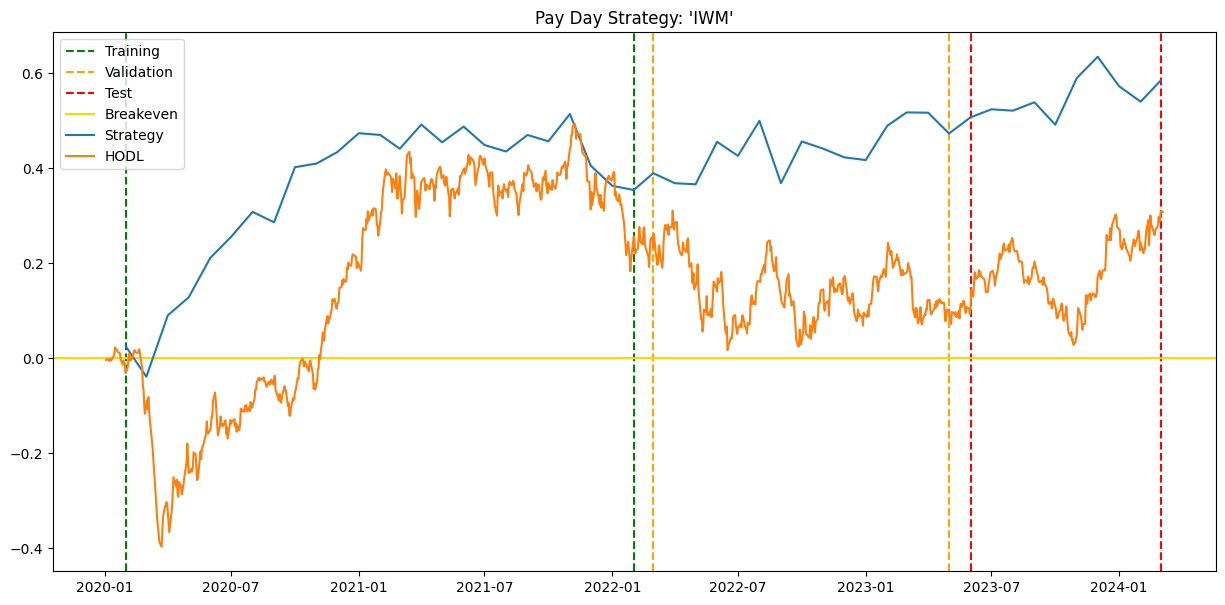

In [16]:
train_dates = utils.get_training(df["strat_ret"]).index.tolist()
valid_dates = utils.get_validation(df["strat_ret"]).index.tolist()
test_dates = utils.get_test(df["strat_ret"]).index.tolist()

fig, ax = plt.subplots(figsize=(15, 7))

ax.axvline(x=train_dates[0], label="Training", color="green", linestyle="--")
ax.axvline(x=train_dates[-1], color="green", linestyle="--")
ax.axvline(x=valid_dates[0], label="Validation", color="orange", linestyle="--")
ax.axvline(x=valid_dates[-1], color="orange", linestyle="--")
ax.axvline(x=test_dates[0], label="Test", color="red", linestyle="--")
ax.axvline(x=test_dates[-1], color="red", linestyle="--")

ax.axhline(y=0, label="Breakeven", color="gold")

ax.plot(df["cum_strat_ret"], label="Strategy")
ax.plot(utils.get_cumulative_return(returns=data[TICKER].pct_change(), total=False), label="HODL")

plt.title(f"Pay Day Strategy: {TICKER!r}")
plt.legend(loc="best")
plt.show()

In [17]:
train_returns = utils.get_training(data["ret"])
valid_returns = utils.get_validation(data["ret"])
test_returns = utils.get_test(data["ret"])

description = pd.concat([
    utils.describe(returns=data.loc[data.index.isin(train_returns.index), "ret"] * pos.loc[pos.index.isin(train_returns.index)],
                   pos=pos.loc[pos.index.isin(train_returns.index)], daily=True, asset=TICKER).to_frame(name="daily_strat_train"),
    # utils.describe(returns=df.loc[(df["enter_date"] >= train_returns.index[0]) & (df["exit_date"] <= train_returns.index[-1]), "strat_ret"],
    #                daily=True, asset=TICKER).to_frame(name="trade_strat_train"),
    utils.describe(returns=train_returns, daily=True, asset=TICKER).to_frame(name="hodl_train"),
    
    utils.describe(returns=data.loc[data.index.isin(valid_returns.index), "ret"] * pos.loc[pos.index.isin(valid_returns.index)],
                   pos=pos.loc[pos.index.isin(valid_returns.index)], daily=True, asset=TICKER).to_frame(name="daily_strat_valid"),
    # utils.describe(returns=df.loc[(df["enter_date"] >= valid_returns.index[0]) & (df["exit_date"] <= valid_returns.index[-1]), "strat_ret"],
    #                daily=True, asset=TICKER).to_frame(name="trade_strat_valid"),
    utils.describe(returns=valid_returns, daily=True, asset=TICKER).to_frame(name="hodl_valid"),
    
    utils.describe(returns=data.loc[data.index.isin(test_returns.index), "ret"] * pos.loc[pos.index.isin(test_returns.index)],
                   pos=pos.loc[pos.index.isin(test_returns.index)], daily=True, asset=TICKER).to_frame(name="daily_strat_test"),
    # utils.describe(returns=df.loc[(df["enter_date"] >= test_returns.index[0]) & (df["exit_date"] <= test_returns.index[-1]), "strat_ret"],
    #                daily=True, asset=TICKER).to_frame(name="trade_strat_test"),
    utils.describe(returns=test_returns, daily=True, asset=TICKER).to_frame(name="hodl_test"),
], axis=1)
description

,daily_strat_train,hodl_train,daily_strat_valid,hodl_valid,daily_strat_test,hodl_test
Asset,IWM,IWM,IWM,IWM,IWM,IWM
Start,2020-01-02,2020-01-02,2022-02-07,2022-02-07,2023-05-05,2023-05-05
End,2022-02-04,2022-02-04,2023-05-04,2023-05-04,2024-03-04,2024-03-04
Mean Return,0.16647%,0.05893%,0.13705%,-0.02908%,0.11110%,0.10391%
Total Return,34.23%,22.52%,16.17%,-12.54%,8.53%,22.06%
Median Return,0.11054%,0.10031%,0.13179%,0.03395%,0.22563%,-0.00260%
1st Quartile,-0.95868%,-0.90920%,-0.95006%,-1.18488%,-0.82353%,-0.81553%
3rd Quartile,1.37827%,1.06116%,1.17313%,1.17235%,0.93177%,0.94750%
Std Dev Return,1.97387%,1.95947%,1.56166%,1.67601%,1.22341%,1.27192%
CAGR,14.729 bps,3.922 bps,12.498 bps,-4.308 bps,10.373 bps,9.590 bps


In [18]:
description = pd.concat([
    utils.describe(returns=df.loc[(df["enter_date"] >= train_returns.index[0]) & (df["exit_date"] <= train_returns.index[-1]), "strat_ret"],
                   daily=True, asset=TICKER).to_frame(name="trade_strat_train"),
    utils.describe(returns=df.loc[(df["enter_date"] >= valid_returns.index[0]) & (df["exit_date"] <= valid_returns.index[-1]), "strat_ret"],
                   daily=True, asset=TICKER).to_frame(name="trade_strat_valid"),
    utils.describe(returns=df.loc[(df["enter_date"] >= test_returns.index[0]) & (df["exit_date"] <= test_returns.index[-1]), "strat_ret"],
                   daily=True, asset=TICKER).to_frame(name="trade_strat_test"),
], axis=1)
description

,trade_strat_train,trade_strat_valid,trade_strat_test
Asset,IWM,IWM,IWM
Start,2020-02-01,2022-03-01,2023-06-01
End,2022-02-01,2023-05-01,2024-03-01
Mean Return,1.31458%,0.64260%,0.77823%
Total Return,35.37%,8.80%,7.59%
Median Return,1.71441%,-0.17026%,1.14040%
1st Quartile,-1.82314%,-1.51855%,-2.05644%
3rd Quartile,3.59762%,5.08937%,2.82160%
Std Dev Return,4.52825%,4.09547%,3.15575%
CAGR,121.875 bps,56.396 bps,73.386 bps


In [19]:
utils.describe(returns=df["strat_ret"], daily=True, asset=TICKER)

Asset                            IWM
Start                     2020-02-01
End                       2024-03-01
Mean Return                 1.00572%
Total Return                  58.46%
Median Return               0.83419%
1st Quartile               -1.67516%
3rd Quartile                3.46374%
Std Dev Return              4.09442%
CAGR                      92.489 bps
Trade CAGR                       N/A
Ann. CAGR                   917.579%
Activity Ratio               100.00%
Number of Trades                 0.0
Average Hold Period       50.00 Days
Daily Sharpe Ratio            0.2456
Ann. Sharpe Ratio             3.8993
Adj. Ann. Sharpe Ratio        3.8993
Daily Sortino Ratio           0.4477
Ann. Sortino Ratio            7.1076
Daily Calmar Ratio            5.5268
Hit Ratio                     52.00%
Profit Factor                  1.91x
MDD                          -10.58%
MDD Start                 2021-11-01
MDD Bottom                2022-02-01
MDD End                   2023-03-01
M